## Funciones e importaciones

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import math as math
import pandas as pd
from scipy.integrate import simps
from scipy.integrate import odeint


'__Definición de funciones__'

def find_nearest(array, value):
    '''
    Recibe un array y un valor; devuelve el valor más cercano al recibido
    '''
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1]
    else:
        return array[idx]

def find_nearest_pos(array, value):
    '''
    Recibe un array y un valor; devuelve el índice del elemento con el valor más cercano al recibido
    '''
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx

def eqX(y):
    '''
    Devuelve concentración de equilibrio en fase sólida a partir de una concentración en fase líquida
    '''
    y = y + 0.05
    KeqX = [15.80011045, 32.02907632, 5.735438305, 0.053726466, 1.972131456]
    eqX = KeqX[0]*KeqX[1]*y/(1+KeqX[1]*y)+KeqX[2] * KeqX[3]*(y-KeqX[4])/(1-KeqX[3]*(y-KeqX[4]))
    return eqX

def m(y):
    '''
    Devuelve el valor del coeficiente de distribución para una determinada concentración en fase líquida
    '''
    m = y/eqX(y)
    return m

def batch(F, t):
    '''
    '''
    x = F[0]
    y = F[1]

    dxdt = -K * (x - eqX(y))
    dydt = (1-eps)/eps * K * (x - eqX(y))

    return [dxdt, dydt]

def column(F, t):
    '''
    '''

    x = F[::2]
    y = F[1::2]

    y[0] = 0

    dFdt = np.empty_like(F)

    dxdt = dFdt[::2]
    dydt = dFdt[1::2]

    '__Fase Sólida_______________________________________________________________________________'

    # A lo largo del extractor el sólido se mantiene estático por lo que ambos términos
    # de transporte son iguales a cero y solo se rige por el término de transferencia de masa

    dxdt[:] = - K * (x[:] - eqX(y[:]))


    '__Fase Líquida_______________________________________________________________________________'
    
    dydt[0]        = 0      

    # A lo largo del extractor se considera la ecuación general
    difusionL      = eps * Dax * np.diff(y[:], 2)/dz**2
    conveccionL    = L/A * np.diff(y[:-1], 1)/dz
    transferenciaL = (1-eps)*K*(x[1:-1] - eqX(y[1:-1]))

    dydt[1:-1]     = (
        + difusionL 
        - conveccionL 
        + transferenciaL
        )/eps

    dydt[-1]       = (
        + eps * Dax * (2*y[-1]-2*y[-2])/(dz**2)
        - L/A*(y[-1]-y[-2])/dz 
        + (1-eps)*K*(x[-1] - eqX(y[-1]))
        )/eps
        
    '____________________________________________________________________________________________'

    return dFdt


def countercurrent(F, t):
    '''
    '''
    x = F[::2]
    y = F[1::2]

    x[-1] = porcentajeAC*dens
    y[0]= 0

    dFdt = np.empty_like(F)

    dxdt = dFdt[::2]
    dydt = dFdt[1::2]

    '____________________________________________________________________________________________'

    dxdt[0] = (S/A*(x[1]-x[0])/dz - (1-eps) * K*(x[0] - eqX(y[0])))/(1-eps)
    
    # A lo largo del extractor se considera la ecuación general
    conveccionS    = S/A * np.diff(x[1:], 1)/dz
    transferenciaS = (1-eps) * K * (x[1:-1] - eqX(y[1:-1]))
    
    dxdt[1:-1]     = (
        + conveccionS 
        - transferenciaS
        )/(1-eps)
    # En el punto de ingreso de sólidos (z = L) no hay variación en función del tiempo
    dxdt[-1]       = 0

    '____________________________________________________________________________________________'
    
    # En el punto de ingreso de solvente (z = 0) se considera que no hay acumulación
    dydt[0]       = 0
        

    # A lo largo del extractor se considera la ecuación general
    difusionL      = Dax * np.diff(y[:], 2)/dz**2
    conveccionL    = L/A * np.diff(y[:-1], 1)/dz
    transferenciaL = (1-eps)*K*(x[1:-1] - eqX(y[1:-1]))

    dydt[1:-1]     = (
        + difusionL 
        - conveccionL 
        + transferenciaL
         )/eps

    dydt[-1]       = (
        + eps * Dax * (2*y[-1] - 2*y[-2])/(dz**2)
        - L/A*(y[-1]-y[-2])/dz 
        + (1-eps)*K*(x[-1] - eqX(y[-1]))
         )/eps
    '____________________________________________________________________________________________'

    return dFdt

   
def error_porcentual(modelo):

    error_porcentual = 0

    for i, dato in enumerate(concentracion_experimental):

        tiempo = tiempo_experimental[i]
        posicion_t = find_nearest_pos(t/60,tiempo)
        
        error = abs((modelo[posicion_t, 1]-dato)/dato)
        error_porcentual += error

    return error_porcentual/(i+1)*100

## Parámetros Generales

In [42]:
'__Fuente de gráficos__'
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = '9'


'__Datos Cinéticos Experimentales'
tiempo_experimental = [1,5,10,15,30,46,80,108,142,168,192,1263,1608]                             # min
concentracion_experimental = [0.11,0.21,0.3,0.46,0.72,0.93,1.3,1.37,1.59,1.62,1.58,1.64,1.76]    # g/L
datos_experimentales = [[tiempo_experimental],[concentracion_experimental]]


kb = 1.38*10**-23 # Constante de Boltzmann
e = math.e
pi = math.pi


# Temperatura de trabajo
T = 25 + 273


# Definición de propiedades
porcentajeAC = 0.06                                                 # Porcentaje de Ácido Carnósico
dens = 557.82                                                       # Densidad del sólido
densb = 180                                                         # Densidad del lecho
densL = 935.69                                                      # Densidad de fase líquida
Deff = (1.3*(10**-10))/60                                           # Difusividad efectiva en sólido
phi = 2.012453362                                                   # Factor de forma
a = 0.000706498099                                                  # Longitud característica
ap = 3362                                                           # Área equivalente
Deq = 6/ap                                                          # Diámetro equivalente a esfera
eps = 1.-densb/dens                                                 # Porosidad del lecho

# Propiedades estimadas
viscH2O = e**(
                - 52.843 + 3703.6/T
                + 5.866*math.log(T)
                - 5.98*10**(-29)*(T)**10
            )
viscEtOH = e**(
                7.875+781.98/T
                - 3.0418*math.log(T)
                ) 
visc = 0.01
rad = math.pow(326.5*(3/(4*pi)), 1/3)*10**(-10)                     # radio molecular de van der waals de la molécula
Dab = kb*T/(6*pi*visc*rad)                                          # Ecuación de Einstein para difusividad


# Definición de parámetros de diseño
Lc = 4.3                                                            # Longitud del equipo
Dc = 0.3                                                            # Diámetro del equipo
A = math.pi*(Dc/2)**2                                               # Área del equipo


# Definición de parámetros de proceso
W = 1000/(3600*24*7*4)                                              # Materia prima a tratar, por hora (7 horas, 5 días, 4  semanas)
S = W/densb                                                         # Flujo volumétrico de sólidos (m³/s)
L = A*Lc*eps/(4*3600)                                               # Flujo volumétrico de solvente (m³/s)
tau = 8*3600                                                        # Tiempo máximo a calcular en la simulación


# Estimación de números adimensionales y coeficientes
Re = (L/A)*Deq*densL/(visc*(1-eps))                                 # Número de Reynolds
Pe = 0.2/eps + 0.011/eps + math.pow(eps*Re, 0.48)                   # Número de Peclet
Sc = visc/(densL*Dab)                                               # Numero de Schmidt   
ShL = (0.765/(Re**0.82) + 0.365/(Re**0.386))*Re*(Sc**(1/3))/eps     # Número de Sherwood
Dax = Deq*(L/A)/(eps*Pe)                                            # Dispersión axial
kL = ShL*Dab/a                                                      # Transferencia de masa en fase líquida
Bi = kL*a/Deff                                                      # Número de Biot

# Definición de la constante global de transferencia de masa
K = 8.07*10**-9
K = K*ap
K = 0.0003022438

# Cálculos

## Extracciones batch

#### __Ajuste de K y comparación de datos experimentales con modelo__

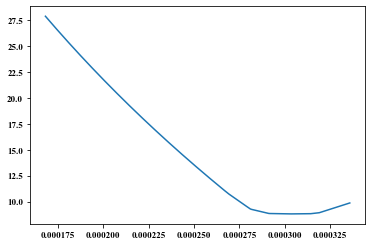


Mínimo error porcentual: 8.8% con Ka = 0.0003022438



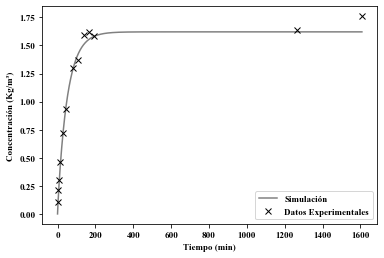


rendimiento_l = 0.5400162807068276
rendimiento_s = 0.540016280706827
Ka: 0.0003022438 s⁻¹



In [3]:
'__Ajuste de K y comparación de datos experimentales con modelo__'

# Valor de la porosidad de lecho en las condiciones experimentales
eps = 0.9177
# Intervalo de tiempo en el cual resolver
t = np.linspace(0,tiempo_experimental[-1]*60,100000)
# Condiciones iniciales
x0=porcentajeAC*dens
y0=0
# Lista vacía para llenar con los valores de Ka utilizados
mat_Ka = np.array([])
# Lista vacía para llenar con los errores porcentuales correspondientes 
# a cada Ka
mat_error = np.array([])

# Iteración entre valores de Ka, 
# solución de sistema de ODEs
# Calculo de error porcentual
# Añadido de valor de Ka a lista
# Añadido de error porcentual a lista
for K in range(50000,100000,100):
    K = K*10**-12*ap
    sol = odeint(batch,[x0,y0],t)
    error = error_porcentual(sol)
    mat_Ka = np.append(mat_Ka, K)
    mat_error = np.append(mat_error, error)

# Graficación del error porcenctual en función de cada Ka
plt.plot(mat_Ka,mat_error)
plt.show()

# Defino K como el que dio el mínimo error cuadrado y vuelvo a calcular
K = float(mat_Ka[np.where(mat_error == mat_error.min())])
print(f'\nMínimo error porcentual: {round(mat_error.min(),2)}% con Ka = {K}\n')
sol = odeint(batch,[x0,y0],t)

# Grafico
plt.plot(t/60, sol[:,1], label="Simulación",color='grey')
plt.plot(tiempo_experimental, concentracion_experimental,
marker='x',linestyle=' ', label='Datos Experimentales', color='black')
plt.xlabel('Tiempo (min)')
plt.ylabel('Concentración (Kg/m³)')
plt.legend()
plt.show()

rendimiento_solido = 1 - sol[-1,0]/(porcentajeAC*dens)
rendimiento_liquido = sol[-1,1]*eps/(sol[0,0]*(1-eps))
print(f'''
rendimiento_l = {rendimiento_liquido}
rendimiento_s = {rendimiento_solido}
Ka: {K} s⁻¹
''')

#### __Calculo de batchs variando densidad de lecho__


    Rendimiento a epsilon: 0.677 -> 0.460
    Concentración final:   7.342 	 Kg/m³
    Volumen:               0.066 	 m³
    

    Rendimiento a epsilon: 0.737 -> 0.486
    Concentración final:   5.794 	 Kg/m³
    Volumen:               0.081 	 m³
    

    Rendimiento a epsilon: 0.798 -> 0.507
    Concentración final:   4.306 	 Kg/m³
    Volumen:               0.105 	 m³
    

    Rendimiento a epsilon: 0.858 -> 0.524
    Concentración final:   2.911 	 Kg/m³
    Volumen:               0.150 	 m³
    

    Rendimiento a epsilon: 0.918 -> 0.540
    Concentración final:   1.621 	 Kg/m³
    Volumen:               0.259 	 m³
    


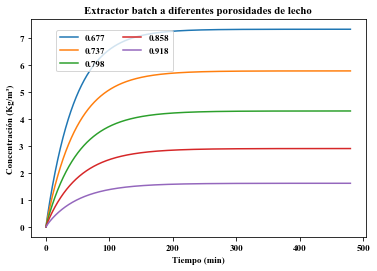

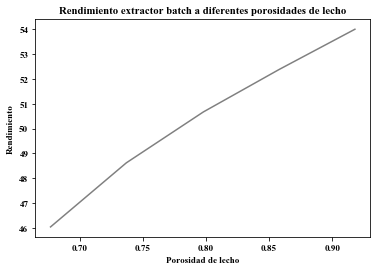

In [4]:
'__Calculo de batchs variando densidad de lecho__'

soluciones = []
rendimientos = []
epsilons = np.linspace(1-densb/dens, 0.9177, 5)
for eps in epsilons:

    nt = 10000
    t = np.linspace(0,tau, nt)
    x0 = porcentajeAC*dens
    y0 = 0
    
    sol = odeint(batch, [x0,y0], t)
    
    rendimiento = 1-sol[-1][0]/sol[0][0]
    rendimientos.append(round(rendimiento*100,2))

    print(f'''
    Rendimiento a epsilon: {eps:.3f} -> {1-sol[-1][0]/sol[0][0]:.3f}
    Concentración final:   {sol[-1][-1]:.3f} \t Kg/m³
    Volumen:               {W*t[-1]/((1-eps)*dens):.3f} \t m³
    ''')
    soluciones.append([eps,sol])

for sol in soluciones:
    plt.plot(t/60, sol[1][:,1],label=f"{round(sol[0],3)}")

plt.title("Extractor batch a diferentes porosidades de lecho")
plt.legend(loc='upper center', bbox_to_anchor=(0.25, +0.97), shadow=False, ncol=2)
plt.xlabel('Tiempo (min)')
plt.ylabel('Concentración (Kg/m³)')
plt.show()


plt.plot(np.round(epsilons,3),rendimientos, color='grey')
plt.xlabel('Porosidad de lecho')
plt.ylabel('Rendimiento')
plt.title("Rendimiento extractor batch a diferentes porosidades de lecho")
plt.show()

# Epsilon elegido para seguir trabajando
eps = 0.737 

#### __Calculo de tres batchs en serie__

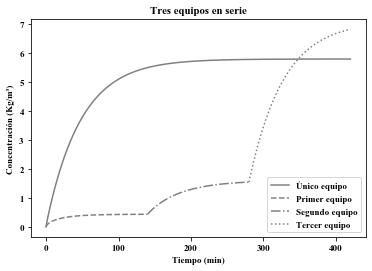


Concentración final con un equipo:    5.804 	 Kg/m³
Concentración final con tres equipos: 6.833 	 Kg/m³
Rendimiento con tres equipos:         57.210 	 %
Rendimiento 1er equipo:               7.882 	 %
Rendimiento 2do equipo:               16.718 	 %
Rendimiento 3er equipo:               53.549 	 %
Volumen con un equipo:                0.071 	 m³
Volumen individual tres equipos:      0.024 	 m³
Mejora Porcentual con tres equipos:   17.730 	 m³



In [5]:
'__Calculo de tres batchs en serie__'

tau = 7*3600
t = np.linspace(0,tau, nt)

t1 = t[:int(nt/3)]
t2 = t[int(nt/3):int(nt*2/3)]
t3 = t[int(nt*2/3):]

sol0 = odeint(batch,[x0,y0],t)
sol1 = odeint(batch, [sol0[-1][0],y0], t1)
sol2 = odeint(batch, [sol1[-1][0],y0], t2)
sol3 = odeint(batch, [sol2[-1][0],y0], t3)

lista = []

for i in range(0,10):
    sol1 = odeint(batch, [sol2[-1][0], y0], t1)
    sol2 = odeint(batch, [sol3[-1][0], sol1[-1][1]], t2)
    sol3 = odeint(batch, [x0, sol2[-1][1]], t3)
    lista.append(sol3[-1][1])

plt.plot(t/60, sol0[:, -1], ls='solid', color='grey', label='Único equipo')
plt.plot(t1/60, sol1[:, -1], ls='dashed', color='grey', label='Primer equipo')
plt.plot(t2/60, sol2[:, -1], ls='dashdot', color='grey', label="Segundo equipo")
plt.plot(t3/60, sol3[:, -1], ls='dotted', color='grey', label="Tercer equipo")

conc_final_3 = sol3[-1,-1]
rendimiento_3 = 100*(1 - sol1[-1][0]/sol3[0][0])

rendimiento_3_1 = 100*(1- sol1[-1][0]/sol1[0][0])
rendimiento_3_2 = 100*(1- sol2[-1][0]/sol2[0][0])
rendimiento_3_3 = 100*(1- sol2[-1][0]/sol3[0][0])

V_1 = W*t[-1]/((1-eps)*dens)
V_3 = W*t1[-1]/((1-eps)*dens)

plt.title('Tres equipos en serie')
plt.xlabel('Tiempo (min)')
plt.ylabel('Concentración (Kg/m³)')
plt.legend()
plt.show()

print(f'''
Concentración final con un equipo:    {sol0[-1][1]:.3f} \t Kg/m³
Concentración final con tres equipos: {conc_final_3:.3f} \t Kg/m³
Rendimiento con tres equipos:         {rendimiento_3:.3f} \t %
Rendimiento 1er equipo:               {rendimiento_3_1:.3f} \t %
Rendimiento 2do equipo:               {rendimiento_3_2:.3f} \t %
Rendimiento 3er equipo:               {rendimiento_3_3:.3f} \t %
Volumen con un equipo:                {V_1:.3f} \t m³
Volumen individual tres equipos:      {V_3:.3f} \t m³
Mejora Porcentual con tres equipos:   {100*(sol3[-1][1]-sol0[-1][1])/sol0[-1][1]:.3f} \t m³
''')

#### __Calculo de dos batchs en serie__

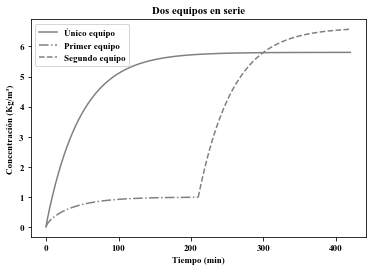

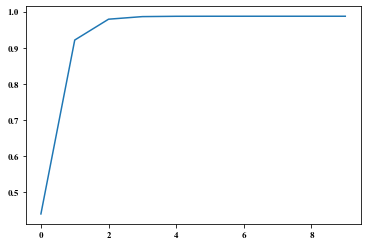


Concentración final con dos equipos:     6.573    Kg/m³
Rendimiento con dos equipos:             55.036   %
Rendimiento 1er equipo:                  15.529   %
Rendimiento 2do equipo:                  46.770   %
Volumen con un equipo:                   0.071    m³
Volumen individual dos equipos:          0.035    m³
Mejora Porcentual con dos equipos:       13.255   %



In [6]:
'__Calculo de dos batchs en serie__'

convergencia = []

t1 = t[:int(nt/2)]
t2 = t[int(nt/2):]

for i in range(0,10):
    sol1 = odeint(batch, [sol2[-1][0], y0], t1)
    sol2 = odeint(batch, [x0, sol1[-1][-1]], t2)
    convergencia.append(sol1[-1][1])

conc_final_2 = sol2[-1][-1]
rendimiento_2 = 100*(1 - sol1[-1][0]/sol2[0][0])

rendimiento_2_1 = 100 * (1 - sol1[-1][0]/sol1[0][0])
rendimiento_2_2 = 100 * (1 - sol2[-1][0]/sol2[0][0])

V_1 = W * t[-1]/((1-eps)*dens)
V_2 = W * t1[-1]/((1-eps)*dens)

# Fase Líquida
plt.plot(t/60, sol0[:, -1], ls='-', color='grey', label='Único equipo')
plt.plot(t1/60, sol1[:,-1], ls='-.', color='grey', label = 'Primer equipo')
plt.plot(t2/60, sol2[:,-1], ls='--', color='grey', label = 'Segundo equipo')

plt.title('Dos equipos en serie')
plt.xlabel('Tiempo (min)')
plt.ylabel('Concentración (Kg/m³)')
plt.legend()
plt.show()

plt.plot(convergencia)
plt.show()

print(f'''
Concentración final con dos equipos:     {conc_final_2:.3f}    Kg/m³
Rendimiento con dos equipos:             {rendimiento_2:.3f}   %
Rendimiento 1er equipo:                  {rendimiento_2_1:.3f}   %
Rendimiento 2do equipo:                  {rendimiento_2_2:.3f}   %
Volumen con un equipo:                   {V_1:.3f}    m³
Volumen individual dos equipos:          {V_2:.3f}    m³
Mejora Porcentual con dos equipos:       {100*(sol2[-1][1]-sol0[-1][1])/sol0[-1][1]:.3f}   %
''')

### Conclusiones parciales

Acá escribiré algo, supongo

## __Extracción en columna__

In [54]:
'__Redefinición de parámetros__'
W   = 5000/(4*5)          # Kg/día Una tonelada mensual, dividida en 4 semanas y 5 días
Dc  = 0.5                 # m
A   = pi*(Dc**2)/4 
Lc  = (W/densb)/A         # Calculo del volumen de la columna en función del volumen de materia prima a tratar
eps = 1 - densb/dens     # Asumo porosidad de lecho como la máxima alcanzable
L   = A*Lc*eps/(4*3600)     # Caudal de solvente, en m³/s
tau = 8*3600
resTimeL = A*Lc*eps/L

print(f'''
Materia prima diaria: {W} Kg
Parámetros de diseño
Largo columna:        {Lc}
Diámetro columna:     {Dc}
Flujo de solvente:    {L*1000*3600}

''')




Materia prima diaria: 250.0 Kg
Parámetros de diseño
Largo columna:        7.07355302630646
Diámetro columna:     0.5
Flujo de solvente:    235.1789107597433




### Cálculos

In [60]:
'___Cálculos____'

# Número de puntos
nz = 500
nt = tau

# Condiciones iniciales
eqLiq = 16.03

Z = np.linspace(0, Lc, nz)         
t = np.linspace(0, tau, nt)

dz = Z[1] - Z[0]
dt = t[1] - t[0]

F0 = np.ones(2*nz)

F0[0::2] = porcentajeAC*dens
F0[1::2] = eqLiq

sol = odeint(column, F0, t, ml=1, mu=2)

# Separo los resultados en una variable para
# las concentraciones en el sólido y otra para
# las concentraciones en el líquido

X = sol[:, 0::2]
Y = sol[:, 1::2]


### Gráficos columna simple

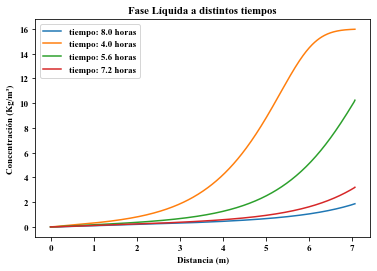

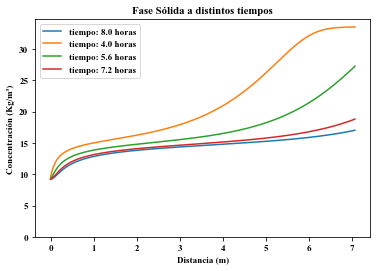

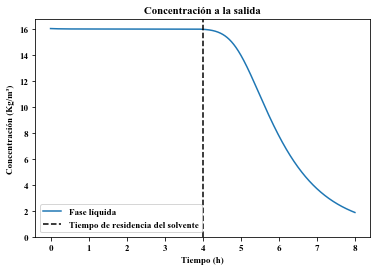


Concentración Promedio: 8.618013640430569
rendimiento_liquido: 0.5404733495650856
rendimiento_solido: 0.5707162902915979



In [61]:
'__Obtención de gráficos__'

# Definición de un tiempo inicial para analizar y el máximo índice de z
zEnd = int(nz)
Yout = Y[:, -1]
resTimeLPos = find_nearest_pos(t, resTimeL)

# Obtengo tiempos a los cuales deseo extraerles información
tiempos = [nt-1]
for i in range(resTimeLPos, int(nt), int(nt/5)):
    tiempos.append(i)

# Grafico concentraciones de fase líquida
for i in tiempos:
    plt.plot(Z[:], Y[i, :], label=f'tiempo: {round(t[i]/3600, 1)} horas')


plt.title('Fase Líquida a distintos tiempos')
plt.xlabel('Distancia (m)')
plt.ylabel('Concentración (Kg/m³)')
plt.legend()
plt.show()


# Grafico concentraciones de fase sólida
for i in tiempos:
    plt.plot(Z[:], X[i, :], label=f'tiempo: {round(t[i]/3600, 1)} horas')

plt.title('Fase Sólida a distintos tiempos')
plt.xlabel('Distancia (m)')
plt.ylabel('Concentración (Kg/m³)')
plt.ylim(ymin=0)
plt.legend()
plt.show()


# Grafico concentración a la salida del extractor
plt.plot(t[:]/3600, Yout[:], label='Fase líquida')

plt.title('Concentración a la salida')
plt.xlabel('Tiempo (h)')
plt.ylabel('Concentración (Kg/m³)')
plt.axvline(x=resTimeL/3600, color='black', ls='--', label='Tiempo de residencia del solvente')
plt.ylim(ymin=0)
plt.legend()
plt.show()

concentracion_promedio = Yout[resTimeLPos:].mean()
rendimiento_liquido = L*concentracion_promedio*(t[-1] - resTimeL)/(A*Lc*densb*porcentajeAC)
rendimiento_solido = 1 - X[-1, :].mean()/(dens*porcentajeAC)

print(f'''
Concentración Promedio: {concentracion_promedio}
rendimiento_liquido: {rendimiento_liquido}
rendimiento_solido: {rendimiento_solido}
''')

In [62]:
## Cálculos en dos columnas en serie CC

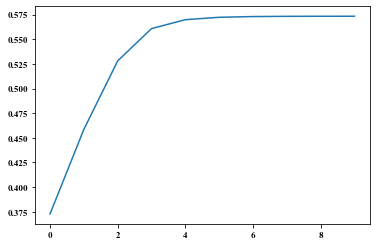

In [63]:
'____Cálculos____'

# Número de puntos
nz = 100
nt = tau

# Condiciones iniciales
eqLiq = 16.03

Z = np.linspace(0, 2*Lc, nz)         
t = np.linspace(0*3600, tau, nt)

dz = Z[1] - Z[0]
dt = t[1] - t[0]

F0 = np.ones(2*nz)

half = int(F0.shape[0]/2)
end  = int(F0.shape[0]) 

F0[0::2] = porcentajeAC*dens
F0[1::2] = eqLiq

sol = odeint(column, F0, t, ml=1, mu=2)

FF = np.ones_like(F0)
sol[-1, ::] = F0[::]
rendimientos = []

for i in range(0,10):

    FF[0:half:2] = sol[-1, half:end:2]
    FF[1:half+1:2] = sol[-1, half+1:end:2]

    FF[half:end:2] = porcentajeAC*dens
    FF[half+1:end:2] = eqLiq

    sol = odeint(column,FF, t, ml=1, mu=2)
    rendimiento_solido = 1 - (sol[-1,:300:2].mean()/(porcentajeAC*dens))
    rendimientos.append(rendimiento_solido)

# Separo los resultados en una variable para
# las concentraciones en el sólido y otra para
# las concentraciones en el líquido
plt.plot(rendimientos)
X = sol[:, ::2]
Y = sol[:, 1::2]

0
5760
11520
17280
23040


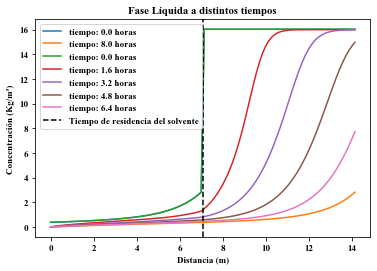

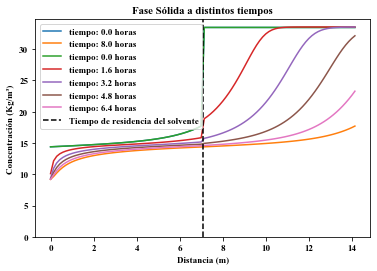

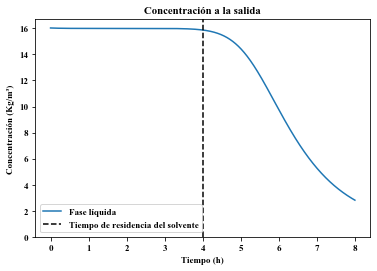


Concentración Promedio: 9.73096353795047
rendimiento_liquido: 0.610271308132792
rendimiento_solido: 0.5733380365848028



In [64]:
'__Obtención de gráficos__'

# Definición de un tiempo inicial para analizar y el máximo índice de z
zEnd = int(nz)
Yout = Y[:, -1]
resTimeLPos = find_nearest_pos(t, resTimeL)

# Obtengo tiempos a los cuales deseo extraerles información
tiempos = [0,int(nt-1)]
for i in range(0, int(nt), int(nt/5)):
    print(i)
    tiempos.append(i)

# Grafico concentraciones de fase líquida
for i in tiempos:
    plt.plot(Z[:], Y[i, :], label=f'tiempo: {round(t[i]/3600, 1)} horas')


plt.title('Fase Líquida a distintos tiempos')
plt.xlabel('Distancia (m)')
plt.ylabel('Concentración (Kg/m³)')
plt.axvline(x=Lc, color='black', ls='--', label='Tiempo de residencia del solvente')
plt.legend()
plt.show()


# Grafico concentraciones de fase sólida
for i in tiempos:
    plt.plot(Z[:], X[i, :], label=f'tiempo: {round(t[i]/3600, 1)} horas')

plt.title('Fase Sólida a distintos tiempos')
plt.xlabel('Distancia (m)')
plt.ylabel('Concentración (Kg/m³)')
plt.axvline(x=Lc, color='black', ls='--', label='Tiempo de residencia del solvente')
plt.ylim(ymin=0)
plt.legend()
plt.show()


# Grafico concentración a la salida del extractor
plt.plot(t[:]/3600, Yout[:], label='Fase líquida')

plt.title('Concentración a la salida')
plt.xlabel('Tiempo (h)')
plt.ylabel('Concentración (Kg/m³)')
plt.axvline(x=resTimeL/3600, color='black', ls='--', label='Tiempo de residencia del solvente')
plt.ylim(ymin=0)
plt.legend()
plt.show()

concentracion_promedio = Yout[resTimeLPos:].mean()
rendimiento_liquido = L*concentracion_promedio*(t[-1] - resTimeL)/(A*Lc*densb*porcentajeAC)
rendimiento_solido = 1 - X[-1, :150].mean()/(dens*porcentajeAC)

print(f'''
Concentración Promedio: {concentracion_promedio}
rendimiento_liquido: {rendimiento_liquido}
rendimiento_solido: {rendimiento_solido}
''')

In [31]:
tiempos

[0, 93678.19087341004, 0, 18735, 37470, 56205, 74940, 93675]

## __Continuo Contracorriente__

In [103]:
'__Redefinición de parámetros__'
Dc  = 0.3                 
A   = pi*(Dc**2)/4 
Lc  = 3                  

densb = 130
eps = 1 - densb/dens        
S = 5000/(4*7*24*3600)/dens
L   = 20/3600/1000                   # Caudal de solvente, en m³/s
resTimeL = A*Lc*eps/L
resTimeS = A*Lc*(1-eps)/S
tau = 3*resTimeL
print(f'''
Materia prima diaria: {S*24*3600} m³
Parámetros de diseño:
Largo equipo:         {Lc} m
Diámetro de contacto: {Dc} m
Flujo de solvente:    {L*1000*3600} L/h
Tiempo Residencia L:  {resTimeL/3600} h
Tiempo Residencia S:  {resTimeS/3600} h
''')


Materia prima diaria: 0.32012374703565405 m³
Parámetros de diseño:
Largo equipo:         3 m
Diámetro de contacto: 0.3 m
Flujo de solvente:    20.0 L/h
Tiempo Residencia L:  8.131874207761287 h
Tiempo Residencia S:  3.705068711937659 h



In [104]:
'____Cálculos____'

# Número de puntos
nz = 50
nt = tau

# Condiciones iniciales
eqLiq = 16.03

Z = np.linspace(0, Lc, nz)         
t = np.linspace(0, tau ,nt)

dz = Z[1] - Z[0]
dt = t[1] - t[0]

F0 = np.ones(2*nz)

F0[0::2] = 0
F0[1::2] = 0

sol = odeint(countercurrent, F0, t, ml=1, mu=2)

# Separo los resultados en una variable para
# las concentraciones en el sólido y otra para
# las concentraciones en el líquido

X = sol[:,  ::2]
Y = sol[:, 1::2]

#### Gráficos

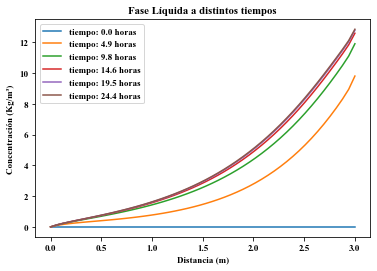

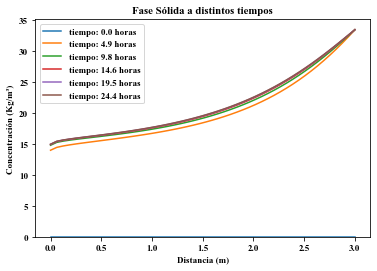

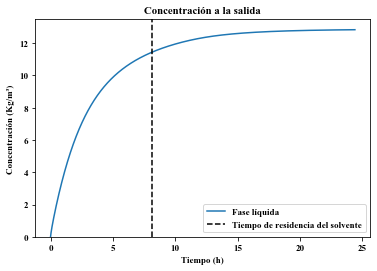


Concentración final: 12.84
rendimiento_solido: 0.5530283838764816
rendimiento_liquido: 0.5751654785117792



In [105]:
'__Obtención de gráficos__'

# Definición de un tiempo inicial para analizar y el máximo índice de z
zEnd = int(nz)

# Concentración a las salidas y entradas del extractor
Yin  = Y[:,  0]
Yout = Y[:, -1]
Xin  = X[:, -1]
Xout = X[:,  0]

resTimePos = find_nearest_pos(t, resTimeL)

# Obtengo tiempos a los cuales deseo extraerles información
tiempos = []
for i in range(int(0), int(nt), int((nt)/5)):
    tiempos.append(i)

# Grafico concentraciones de fase líquida
for i in tiempos:
    plt.plot(Z[:zEnd], Y[i, 0:zEnd], label=f'tiempo: {round(t[i]/3600, 1)} horas')


plt.title('Fase Líquida a distintos tiempos')
plt.xlabel('Distancia (m)')
plt.ylabel('Concentración (Kg/m³)')
plt.legend()
plt.show()


# Grafico concentraciones de fase sólida
for i in tiempos:
    plt.plot(Z[:zEnd], X[i, 0:zEnd], label=f'tiempo: {round(t[i]/3600, 1)} horas')

plt.title('Fase Sólida a distintos tiempos')
plt.xlabel('Distancia (m)')
plt.ylabel('Concentración (Kg/m³)')
plt.ylim(ymin=0)
plt.legend()
plt.show()


# Grafico concentración a la salida del extractor
plt.plot(t[:]/3600, Yout[:], label='Fase líquida')
plt.title('Concentración a la salida')
plt.xlabel('Tiempo (h)')
plt.ylabel('Concentración (Kg/m³)')
plt.axvline(x=resTimeL/3600, color='black', ls='--', label='Tiempo de residencia del solvente')
plt.ylim(ymin=0)
plt.legend()
plt.show()


rendimiento_liquido = ((Yout[-1]-Yin[-1])*L)/(porcentajeAC*S*dens)
rendimiento_solido = 1 - Xout[-1]/(porcentajeAC*dens)

print(f'''
Concentración final: {round(Yout[-1],2)}
rendimiento_solido: {rendimiento_solido}
rendimiento_liquido: {rendimiento_liquido}
''')